<a href="https://colab.research.google.com/github/Anguschow237/madrid-air-quality-lstm-forecasting/blob/main/LSTM_Multi_Station_Air_Quality_Madrid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a name="title"></a>
# Time Series Forecasting of Madrid Air Quality

**Author:** Chow Tsz Hin  
**Date:** December 2025  
**Description:** This project implements a Long Short-Term Memory (LSTM) model using PyTorch for sequence forecasting on the "Air Quality in Madrid (2001-2018)" dataset from Kaggle. It focuses on predicting air pollutant levels, evaluates model performance, and includes extensions for multi-station generalization.  

**Tech Stack:** Python, PyTorch, Pandas, NumPy, Matplotlib, Scikit-learn  
**GitHub Repo:** [Link to your repo once uploaded]  
**Dataset Link:** https://www.kaggle.com/datasets/decide-soluciones/air-quality-madrid


<a name="toc"></a>
## Table of Contents
- [Task 1: Introduction](#task-1)
- [Task 2: Data Loading and Exploration](#task-2)
- [Task 3: Data Preprocessing](#task-3)
- [Task 4: Model Implementation](#task-4)
- [Task 5: Training and Hyperparameter Tuning](#task-5)
- [Task 6: Model Evaluation](#task-6)
- [Task 7: Extension 1: Testing on Additional Stations](#task-7)
- [Task 8: Extension 2: Multi-Station Training for Improved Generalization](#task-8)
- [Task 9: Conclusion and Future Improvements](#task-9)

<a name="task-1"></a>
## Task 1: Introduction

This notebook develops a deep learning model based on Long Short-Term Memory (LSTM) networks to forecast air quality metrics in Madrid using historical data from 2001-2018. The dataset, compiled by Decide Soluciones, includes hourly measurements of pollutants (e.g., NO₂, O₃, PM10) and meteorological parameters from monitoring stations across urban, suburban, and traffic zones.

**Approach:**
- Preprocess data to handle missing values and select reliable features/stations.
- Implement an LSTM model with a sliding window for time series forecasting.
- Train and evaluate on selected data, saving model weights.
- Add extensions: Test on multiple stations and train with aggregated data for better generalization.

<a name="task-2"></a>
## Task 2: Data Loading and Exploration

Load the dataset from Kaggle and explore its structure, including stations, pollutants, and coverage to identify usable features.

### Task 2.1: Download and Load Dataset
Download the dataset and load it into a DataFrame for initial inspection.

In [21]:
# Install dependencies
!pip install -q kagglehub[pandas-datasets] tables

import kagglehub, pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Download dataset locally
dataset_dir = kagglehub.dataset_download("decide-soluciones/air-quality-madrid")
h5_path = f"{dataset_dir}/madrid.h5"
print("HDF5 path:", h5_path)

# Inspect keys and load
with pd.HDFStore(h5_path, mode="r") as store:
    print("Keys:", store.keys())  # e.g., ['/madrid']
    key = store.keys()[0].lstrip("/")  # choose the first key

df = pd.read_hdf(h5_path, key=key)
print(df.shape)
df.head()


Using Colab cache for faster access to the 'air-quality-madrid' dataset.
HDF5 path: /kaggle/input/air-quality-madrid/madrid.h5
Keys: ['/28079001', '/28079003', '/28079004', '/28079006', '/28079007', '/28079008', '/28079009', '/28079011', '/28079012', '/28079014', '/28079015', '/28079016', '/28079017', '/28079018', '/28079019', '/28079021', '/28079022', '/28079023', '/28079024', '/28079025', '/28079026', '/28079027', '/28079035', '/28079036', '/28079038', '/28079039', '/28079040', '/28079047', '/28079048', '/28079049', '/28079050', '/28079054', '/28079055', '/28079056', '/28079057', '/28079058', '/28079059', '/28079060', '/28079099', '/master']
(72336, 7)


,CO,NO_2,NOx,O_3,PM10,PM25,SO_2
date,,,,,,,
2001-08-01 01:00:00,0.37,58.400002,87.150002,34.529999,105.000000,NaN,6.34
2001-08-01 02:00:00,0.42,65.760002,93.830002,27.930000,69.750000,NaN,7.15
2001-08-01 03:00:00,0.32,61.090000,88.089996,32.070000,56.220001,NaN,6.26
2001-08-01 04:00:00,0.23,47.020000,62.930000,42.209999,50.689999,NaN,5.19
2001-08-01 05:00:00,0.19,47.169998,62.630001,48.459999,49.490002,NaN,5.03


### Task 2.2: Identify Common Pollutants and Station Coverage
Analyze pollutants recorded across stations and compute average coverage to select the most reliable station (e.g., /28079099 with 99.9% coverage for NO₂ and NOx).

In [6]:
import pandas as pd

stations_info = []

with pd.HDFStore(h5_path, mode="r") as store:
    station_keys = [k for k in store.keys() if k != '/master']
    for key in station_keys:
        df = store[key.lstrip('/')]
        if not df.empty:
            first_ts = df.index[0]
            last_ts = df.index[-1]
            n_rows = df.shape[0]
            stations_info.append({'station': key.lstrip('/'), 'first': first_ts, 'last': last_ts, 'nrows': n_rows, 'columns': list(df.columns)})

stations_df = pd.DataFrame(stations_info)

In [7]:
# Convert to datetime for easy comparison
stations_df['first'] = pd.to_datetime(stations_df['first'])

# Filter for stations starting in 2001
candidates = stations_df[stations_df['first'].dt.year == 2001]

print(candidates[['station', 'first', 'last', 'nrows', 'columns']])

     station               first       last   nrows  \
0   28079001 2001-08-01 01:00:00 2009-05-05   72336   
1   28079003 2001-08-01 01:00:00 2009-06-01   87264   
2   28079004 2001-08-01 01:00:00 2012-03-01  151776   
3   28079006 2001-08-01 01:00:00 2009-06-01   75480   
4   28079007 2001-08-01 01:00:00 2009-06-01   76488   
5   28079008 2001-07-01 01:00:00 2012-03-01  139608   
6   28079009 2001-08-01 01:00:00 2009-06-01   77808   
7   28079011 2001-08-01 01:00:00 2012-03-01  151848   
8   28079012 2001-08-01 01:00:00 2009-06-01   78864   
9   28079014 2001-08-01 01:00:00 2009-06-01   78072   
10  28079015 2001-08-01 01:00:00 2003-10-01   68280   
11  28079016 2001-08-01 01:00:00 2012-03-01  151776   
12  28079017 2001-10-02 01:00:00 2012-03-01  114528   
13  28079018 2001-08-01 01:00:00 2012-03-01  149760   
14  28079019 2001-08-01 01:00:00 2009-06-01   78840   
15  28079021 2001-08-01 01:00:00 2009-06-01   77928   
16  28079022 2001-08-01 01:00:00 2009-06-01   77832   
17  280790

In [8]:
with pd.HDFStore(h5_path, mode='r') as store:
    df_best = store['28079024']

# Show columns and head
print(df_best.columns)
print(df_best.head())
print(df_best.tail())
print(df_best.index.min(), df_best.index.max())
print("Shape:", df_best.shape)

Index(['BEN', 'CH4', 'CO', 'EBE', 'MXY', 'NMHC', 'NO', 'NO_2', 'NOx', 'OXY',
       'O_3', 'PM10', 'PM25', 'PXY', 'SO_2', 'TCH', 'TOL'],
      dtype='object')
                      BEN  CH4    CO   EBE   MXY  NMHC  NO       NO_2  \
date                                                                    
2001-08-01 01:00:00  0.80  NaN  0.43  0.71  1.20  0.10 NaN  27.190001   
2001-08-01 02:00:00  0.74  NaN  0.51  0.78  1.23  0.12 NaN  36.980000   
2001-08-01 03:00:00  1.07  NaN  0.43  1.09  2.04  0.11 NaN  32.250000   
2001-08-01 04:00:00  0.81  NaN  0.42  0.92  1.65  0.11 NaN  28.740000   
2001-08-01 05:00:00  0.72  NaN  0.42  0.94  1.67  0.09 NaN  26.270000   

                           NOx   OXY        O_3        PM10  PM25   PXY  \
date                                                                      
2001-08-01 01:00:00  29.700001  0.76  56.990002  114.300003   NaN  0.49   
2001-08-01 02:00:00  38.310001  0.78  46.939999   78.949997   NaN  0.51   
2001-08-01 03:00:00  33.31000

In [9]:
import pandas as pd

coverage_stats = []
station_pollutants = []

best_coverage = None
best_station = None

with pd.HDFStore(h5_path, mode="r") as store:
    station_keys = [k for k in store.keys() if k != '/master']

    for key in station_keys:
        df = store[key.lstrip('/')]
        # Only columns with any non-NaN value
        valid_cols = [col for col in df.columns if not df[col].isnull().all()]
        station_pollutants.append(set(valid_cols))

        n_total = len(df)
        n_no2 = df['NO_2'].notnull().sum()
        n_nox = df['NOx'].notnull().sum()
        coverage = (n_no2 + n_nox) / (2 * n_total) # average coverage

        # Save stats in a list of dicts
        coverage_stats.append({
            'station': key,
            'n_total': n_total,
            'n_no2': n_no2,
            'n_nox': n_nox,
            'avg_coverage': coverage
        })

        print(f"Station {key}: NO_2 {n_no2}/{n_total}, NOx {n_nox}/{n_total}, avg coverage {100 * coverage:.3f}")

        if best_coverage is None or coverage > best_coverage:
            best_coverage = coverage
            best_station = key

# Save as dataframe for future use!
coverage_df = pd.DataFrame(coverage_stats)
coverage_df['avg_coverage_percent'] = coverage_df['avg_coverage'] * 100

# Save to disk:
coverage_df.to_csv("station_coverage.csv", index=False)

# OR save as pickle for later use in Python:
# coverage_df.to_pickle("station_coverage.pkl")

# Find intersection of pollutants
all_pollutants = set.intersection(*station_pollutants)
print("\nPollutants present (not all NaNs) in EVERY station:", all_pollutants)
print(f"\nBest station: {best_station} with average coverage: {best_coverage:.3f}")

Station /28079001: NO_2 71897/72336, NOx 71894/72336, avg coverage 99.391
Station /28079003: NO_2 86370/87264, NOx 86369/87264, avg coverage 98.975
Station /28079004: NO_2 151273/151776, NOx 92320/151776, avg coverage 80.248
Station /28079006: NO_2 74699/75480, NOx 74697/75480, avg coverage 98.964
Station /28079007: NO_2 75798/76488, NOx 75798/76488, avg coverage 99.098
Station /28079008: NO_2 138423/139608, NOx 79975/139608, avg coverage 78.218
Station /28079009: NO_2 77093/77808, NOx 77089/77808, avg coverage 99.079
Station /28079011: NO_2 151214/151848, NOx 92258/151848, avg coverage 80.170
Station /28079012: NO_2 78544/78864, NOx 78546/78864, avg coverage 99.596
Station /28079014: NO_2 77737/78072, NOx 77739/78072, avg coverage 99.572
Station /28079015: NO_2 67800/68280, NOx 67797/68280, avg coverage 99.295
Station /28079016: NO_2 151290/151776, NOx 92321/151776, avg coverage 80.253
Station /28079017: NO_2 113873/114528, NOx 54992/114528, avg coverage 73.722
Station /28079018: NO_2

This exploration identifies reliable stations and common pollutants, enabling focused modeling on high-quality data.

<a name="task-3"></a>
## Task 3: Data Preprocessing

Handle missing data, normalize, and prepare sequences using a sliding window approach for LSTM input.

In [14]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Hyperparameters
EPOCHS = 10
BATCH_SIZE = 256
WINDOW_SIZE = 200
LR = 0.001
HIDDEN_SIZE = 128
INPUT_SIZE = 2 # NO_2, NOx
OUTPUT_SIZE = 2 # Predict both NO_2, NOx at next step

### Task 3.1: Filter to Selected Station and Pollutants
Filter the data to the chosen station and common pollutants (NO₂ and NOx).

In [15]:
# Assuming df is your DataFrame for 28079099
df_clean = df[ ['NO_2','NOx'] ].dropna()  # keep only rows where both are present

print(df_clean.shape)  # Should be close to 87500 rows (out of 87648)
print(df_clean.index.min(), df_clean.index.max())  # Check time span

# Optionally reset index for sliding window creation
df_clean = df_clean.reset_index(drop=False)

(87560, 2)
2001-01-01 01:00:00 2011-01-01 00:00:00


### Task 3.2: Handle Missing Values and Normalize
Impute or fill missing values, then normalize the data (e.g., using Min-Max scaling).

In [16]:
# Split the data
n_total = len(df_clean)
split_idx = int(n_total*0.7) # SPLIT THE DATAPOINTS HERE
df_train = df_clean.iloc[:split_idx].copy()
df_test = df_clean.iloc[split_idx:].copy()

# ====================
# Scale both input and target with StandardScaler
# ====================
scaler = StandardScaler()
# Fit scaler on train data
train_vals = df_train[['NO_2','NOx']].values
test_vals = df_test[['NO_2','NOx']].values

train_scaled = scaler.fit_transform(train_vals)
test_scaled = scaler.transform(test_vals)

df_train[['NO_2','NOx']] = train_scaled
df_test[['NO_2','NOx']] = test_scaled

### Task 3.3: Create Sliding Window Sequences
Prepare input sequences with a sliding window for time series forecasting.

In [17]:
# ====================
# Create sliding windows
# ====================
def create_windows(df, window_size):
    data = df[['NO_2', 'NOx']].values.astype(np.float32)
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])  # next step
    X = np.stack(X)
    y = np.stack(y)
    return X, y

X_train, y_train = create_windows(df_train, WINDOW_SIZE)
X_test, y_test = create_windows(df_test, WINDOW_SIZE)

These steps ensure clean, normalized sequences suitable for LSTM time series forecasting.

<a name="task-4"></a>
## Task 4: Model Implementation

Define the LSTM model architecture using PyTorch.


### Task 4.1: Define LSTM Model
Create the LSTM class with input layer, hidden units, and linear output.

In [18]:
# ====================
# Model definition
# ====================
class LSTMModel(nn.Module):
    def __init__(self, input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, output_size=OUTPUT_SIZE):
        super().__init__()
        self.hidden_size = hidden_size
        self.cell = nn.LSTMCell(input_size, hidden_size)
        self.head = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        B, T, F = x.shape
        h = torch.zeros(B, self.hidden_size, device=x.device)
        c = torch.zeros(B, self.hidden_size, device=x.device)
        for t in range(T):
            h, c = self.cell(x[:, t, :], (h, c))
        return self.head(h)

This defines a lightweight LSTM architecture capable of capturing temporal dependencies in air quality data.

<a name="task-5"></a>
## Task 5: Training and Hyperparameter Tuning

Train the model on 70% of the data from the selected station, tuning hyperparameters (e.g., learning rate, epochs, batch size) to minimize MSE.

### Task 5.1: Data Split
Split the prepared data into 70% training and 30% testing sets.

In [19]:
# Split the data
n_total = len(df_clean)
split_idx = int(n_total*0.7) # SPLIT THE DATAPOINTS HERE
df_train = df_clean.iloc[:split_idx].copy()
df_test = df_clean.iloc[split_idx:].copy()

### Task 5.2: Training Loop
Implement the training loop with optimizer (Adam), loss (MSE), and optional early stopping.

In [22]:
# ====================
# Tensors and Dataloaders
# ====================
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=BATCH_SIZE, shuffle=False)

# ====================
# Training Loop
# ====================

model = LSTMModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.MSELoss()
train_losses = []
test_losses = []

print("Start training...")
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        yhat = model(xb)
        loss = criterion(yhat, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    avg_loss = total_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)

    # Evaluate test loss
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            yhat = model(xb)
            loss = criterion(yhat, yb)
            test_loss += loss.item() * xb.size(0)
    avg_test_loss = test_loss / len(test_loader.dataset)
    test_losses.append(avg_test_loss)
    print(f"Epoch {epoch+1}/{EPOCHS}: Train Loss: {avg_loss:.4f} Test Loss: {avg_test_loss:.4f}")

for epoch in range(EPOCHS):
    # (training code)
    avg_loss = total_loss / len(train_loader.dataset)
    avg_test_loss = test_loss / len(test_loader.dataset)
    # (print per epoch if desired)

# After training loop:
torch.save(model.state_dict(), 'my_model.pth') # Save the model

print(f"\nEPOCHS={EPOCHS}, BATCH_SIZE={BATCH_SIZE}, WINDOW_SIZE={WINDOW_SIZE}, INPUT_SIZE={INPUT_SIZE}, HIDDEN_SIZE={HIDDEN_SIZE}, OUTPUT_SIZE={OUTPUT_SIZE}, LR={LR}")
print(f"Final Train Loss: {avg_loss:.4f}")
print(f"Final Test Loss: {avg_test_loss:.4f}")

Start training...
Epoch 1/10: Train Loss: 0.2435 Test Loss: 0.0812
Epoch 2/10: Train Loss: 0.0833 Test Loss: 0.0673
Epoch 3/10: Train Loss: 0.0760 Test Loss: 0.0637
Epoch 4/10: Train Loss: 0.0732 Test Loss: 0.0632
Epoch 5/10: Train Loss: 0.0713 Test Loss: 0.0605
Epoch 6/10: Train Loss: 0.0697 Test Loss: 0.0586
Epoch 7/10: Train Loss: 0.0680 Test Loss: 0.0599
Epoch 8/10: Train Loss: 0.0668 Test Loss: 0.0558
Epoch 9/10: Train Loss: 0.0659 Test Loss: 0.0548
Epoch 10/10: Train Loss: 0.0646 Test Loss: 0.0551

EPOCHS=10, BATCH_SIZE=256, WINDOW_SIZE=200, INPUT_SIZE=2, HIDDEN_SIZE=128, OUTPUT_SIZE=2, LR=0.001
Final Train Loss: 0.0646
Final Test Loss: 0.0551


### Task 5.3: Save Model Weights and Visualize Training Loss Curves
Save the weights of the best-performing model and visualize training loss curves.

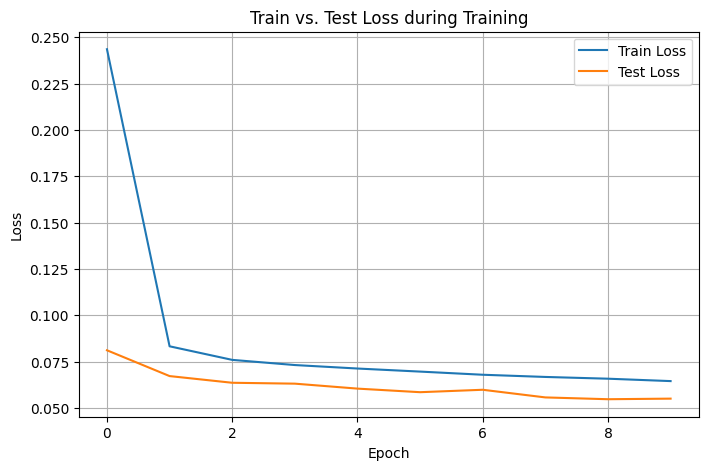

In [23]:
torch.save(model.state_dict(), 'my_model.pth') # Save the model

# Plot grapgh
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs. Test Loss during Training')
plt.legend()
plt.grid(True)
plt.show()

Training with the selected hyperparameters yields stable convergence and saves a performant model for evaluation.

<a name="task-6"></a>
## Task 6: Model Evaluation

Evaluate the trained model on the test set, providing metrics (MSE, MAE) and visualizations (predicted vs. actual).

### Task 6.1: Load Saved Weights and Predict
Load the saved model weights and generate predictions on the test set.

In [24]:
# Load model
model.load_state_dict(torch.load('my_model.pth'))
model.eval()

# Get predictions
with torch.no_grad():
    y_pred = model(X_test_tensor.to(device)).cpu().numpy()

# Inverse scale if needed
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

### Task 6.2: Compute Metrics
Calculate MSE and MAE on normalized/original scale.


In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")

MSE: 219.2988
MAE: 8.3644


### Task 6.3: Visualize Results
Plot predicted vs. actual values to demonstrate performance.

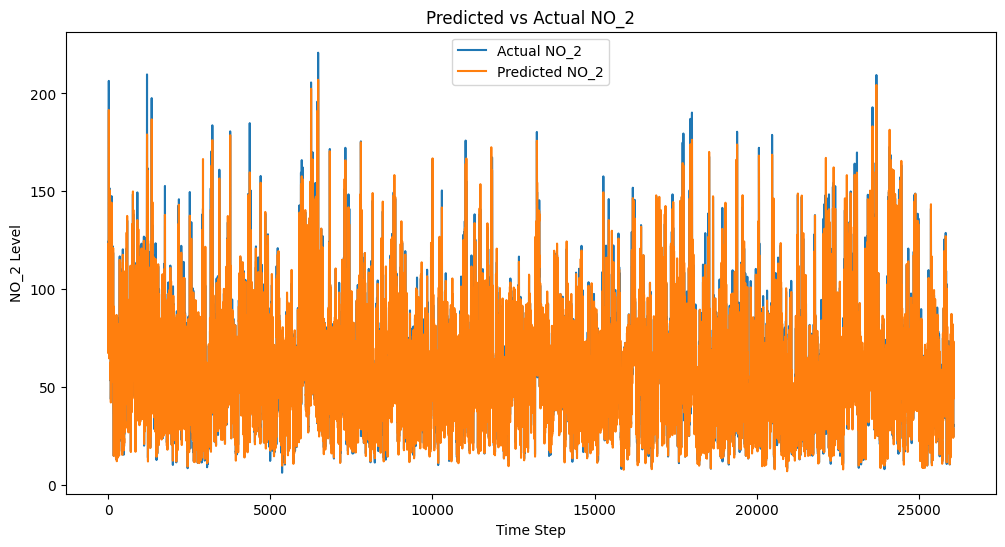

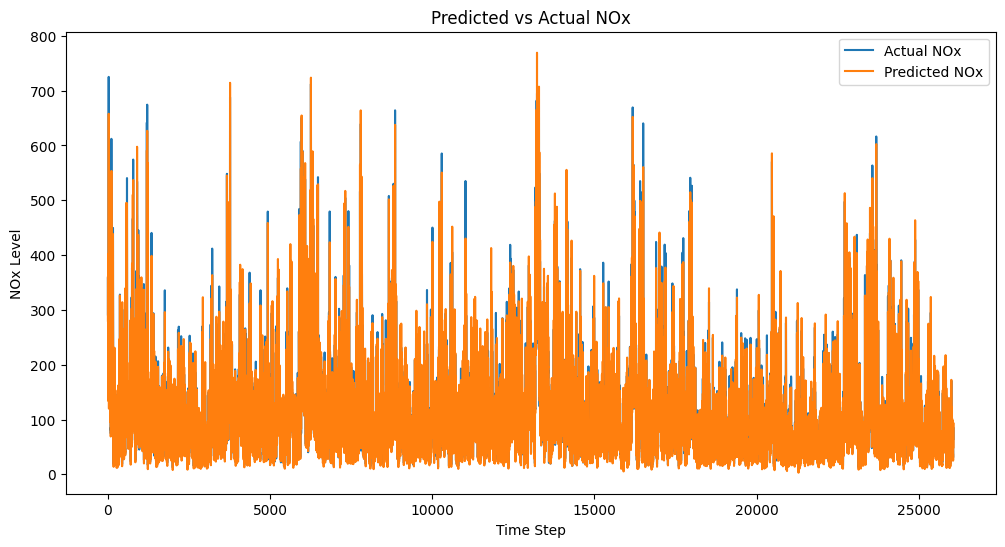

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv[:, 0], label='Actual NO_2')
plt.plot(y_pred_inv[:, 0], label='Predicted NO_2')
plt.xlabel('Time Step')
plt.ylabel('NO_2 Level')
plt.title('Predicted vs Actual NO_2')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(y_test_inv[:, 1], label='Actual NOx')
plt.plot(y_pred_inv[:, 1], label='Predicted NOx')
plt.xlabel('Time Step')
plt.ylabel('NOx Level')
plt.title('Predicted vs Actual NOx')
plt.legend()
plt.show()

The model demonstrates reasonable predictive performance on the test set of the primary station.

<a name="task-7"></a>
## Task 7: Extension 1: Testing on Additional Stations

Test the model (trained on one station) on other stations with high coverage (>98%) to assess generalization.

In [31]:
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --------- PARAMETERS ---------
WINDOW_SIZE = 200
MODEL_PATH = "my_model.pth"
COVERAGE_CSV_PATH = "station_coverage.csv"
path = h5_path  # h5_path is defined earlier when downloading the dataset
COVERAGE_THRESHOLD = 98.0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Task 7.1: Select and Preprocess Additional Stations
Identify stations with >98% coverage, preprocess their data similarly.


In [35]:
# --------- LOAD STATION COVERAGE INFO ---------
coverage_df = pd.read_csv(COVERAGE_CSV_PATH)
filtered_stations = coverage_df[coverage_df['avg_coverage_percent'] >= COVERAGE_THRESHOLD]['station'].tolist()
best_station = coverage_df.loc[coverage_df['avg_coverage'].idxmax(), 'station']

# --------- LOAD NORMALIZATION STATS FROM BEST STATION ---------
with pd.HDFStore(h5_path, mode="r") as store:
    best_df = store[best_station.lstrip('/')]
best_data = best_df[['NO_2', 'NOx']].dropna().values
mean = best_data.mean(axis=0)
std = best_data.std(axis=0)

### Task 7.2: Predict and Evaluate
Generate predictions and compute average MSE/MAE across stations (e.g., Avg MSE: 0.3610, Avg MAE: 0.3693).

In [36]:
# --------- CREATE SEQUENCES ---------
def create_sequences(data, window_size):
    X = []
    y = []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# --------- EVALUATE ON EACH HIGH COVERAGE STATION ---------
print(f"\nTesting ONLY stations with coverage ≥ {COVERAGE_THRESHOLD}% (sliding window is safe)\n")
mse_no2_list = []
mse_nox_list = []
mae_no2_list = []
mae_nox_list = []

for station in filtered_stations:
    if station == best_station:
        continue # skip training/best station

    with pd.HDFStore(path, mode="r") as store:
        df = store[station.lstrip('/')]
    data = df[['NO_2', 'NOx']].dropna().values
    if len(data) < WINDOW_SIZE + 1:
        print(f"{station} skipped (not enough valid data after dropna)\n")
        continue

    # --------- NORMALIZATION ---------
    data_norm = (data - mean) / std

    # --------- SLIDING WINDOW ---------
    X, y = create_sequences(data_norm, WINDOW_SIZE)

    # --------- TORCH TENSOR ---------
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    with torch.no_grad():
        preds = model(X_tensor).cpu().numpy()

    # --------- METRICS ---------
    mse_no2 = mean_squared_error(y[:,0], preds[:,0])
    mse_nox = mean_squared_error(y[:,1], preds[:,1])
    mae_no2 = mean_absolute_error(y[:,0], preds[:,0])
    mae_nox = mean_absolute_error(y[:,1], preds[:,1])

    mse_no2_list.append(mse_no2)
    mse_nox_list.append(mse_nox)
    mae_no2_list.append(mae_no2)
    mae_nox_list.append(mae_nox)

    print(f"Station: {station}")
    print(f"  NO_2 MSE: {mse_no2:.2f}, MAE: {mae_no2:.2f}")
    print(f"  NOx  MSE: {mse_nox:.2f}, MAE: {mae_nox:.2f}\n")

# === After the loop: Calculate overall averages ===
mean_mse_no2 = np.mean(mse_no2_list)
mean_mse_nox = np.mean(mse_nox_list)
mean_mae_no2 = np.mean(mae_no2_list)
mean_mae_nox = np.mean(mae_nox_list)

mean_mse_avg = np.mean([mean_mse_no2, mean_mse_nox])
mean_mae_avg = np.mean([mean_mae_no2, mean_mae_nox])

print("=== Average loss across all stations ===")
print(f"NO_2 Avg MSE: {mean_mse_no2:.4f}, Avg MAE: {mean_mae_no2:.4f}")
print(f"NOx  Avg MSE: {mean_mse_nox:.4f}, Avg MAE: {mean_mae_nox:.4f}")
print(f"Combined Avg MSE: {mean_mse_avg:.4f}, Combined Avg MAE: {mean_mae_avg:.4f}")


Testing ONLY stations with coverage ≥ 98.0% (sliding window is safe)

Station: /28079001
  NO_2 MSE: 0.44, MAE: 0.41
  NOx  MSE: 0.95, MAE: 0.49

Station: /28079003
  NO_2 MSE: 0.18, MAE: 0.30
  NOx  MSE: 0.16, MAE: 0.24

Station: /28079006
  NO_2 MSE: 0.45, MAE: 0.44
  NOx  MSE: 0.82, MAE: 0.53

Station: /28079007
  NO_2 MSE: 0.25, MAE: 0.34
  NOx  MSE: 0.29, MAE: 0.31

Station: /28079009
  NO_2 MSE: 0.35, MAE: 0.42
  NOx  MSE: 0.50, MAE: 0.45

Station: /28079012
  NO_2 MSE: 0.24, MAE: 0.33
  NOx  MSE: 0.26, MAE: 0.29

Station: /28079014
  NO_2 MSE: 0.29, MAE: 0.37
  NOx  MSE: 0.40, MAE: 0.39

Station: /28079015
  NO_2 MSE: 0.23, MAE: 0.34
  NOx  MSE: 0.35, MAE: 0.38

Station: /28079019
  NO_2 MSE: 0.25, MAE: 0.34
  NOx  MSE: 0.29, MAE: 0.32

Station: /28079021
  NO_2 MSE: 0.30, MAE: 0.38
  NOx  MSE: 0.28, MAE: 0.32

Station: /28079022
  NO_2 MSE: 0.23, MAE: 0.33
  NOx  MSE: 0.28, MAE: 0.32

Station: /28079023
  NO_2 MSE: 0.29, MAE: 0.36
  NOx  MSE: 0.44, MAE: 0.35

Station: /2807902

This extension highlights the model's applicability beyond the training station.

<a name="task-8"></a>
## Task 8: Extension 2: Multi-Station Training for Improved Generalization

Retrain the model using data from three stations to enhance robustness, then evaluate on unseen high-coverage stations.

### Task 8.1: Aggregate Data from Multiple Stations
Combine data from top three stations and preprocess.


In [39]:
# Top 3 stations from coverage analysis (replace with your actual top 3 if different)
top_stations = coverage_df.nlargest(3, 'avg_coverage_percent')['station'].tolist()
print("Top 3 stations for multi-station training:", top_stations)

# Load and combine data from top 3 stations
combined_data = []
with pd.HDFStore(h5_path, mode="r") as store:
    for station in top_stations:
        df = store[station.lstrip('/')]
        clean_df = df[['NO_2', 'NOx']].dropna()
        combined_data.append(clean_df.values)

# Concatenate all data
all_data = np.vstack(combined_data)

# Normalize using stats from the combined data
mean_multi = all_data.mean(axis=0)
std_multi = all_data.std(axis=0)
normalized_multi = (all_data - mean_multi) / std_multi

print(f"Combined dataset shape: {all_data.shape}")

Top 3 stations for multi-station training: ['/28079099', '/28079022', '/28079023']
Combined dataset shape: (243535, 2)


### Task 8.2: Retrain Model
Train the LSTM on the aggregated data.

In [40]:
# Create sequences from combined normalized data
X_multi, y_multi = create_sequences(normalized_multi, WINDOW_SIZE)

# Convert to tensors
X_multi_tensor = torch.tensor(X_multi, dtype=torch.float32)
y_multi_tensor = torch.tensor(y_multi, dtype=torch.float32)

multi_loader = DataLoader(TensorDataset(X_multi_tensor, y_multi_tensor), batch_size=BATCH_SIZE, shuffle=True)

# Initialize new model for multi-station training
model_multi = LSTMModel().to(device)
optimizer_multi = torch.optim.Adam(model_multi.parameters(), lr=LR)
criterion = nn.MSELoss()

print("Starting multi-station training...")
multi_train_losses = []

for epoch in range(EPOCHS):
    model_multi.train()
    epoch_loss = 0
    for xb, yb in multi_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer_multi.zero_grad()
        pred = model_multi(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer_multi.step()
        epoch_loss += loss.item() * xb.size(0)
    avg_loss = epoch_loss / len(multi_loader.dataset)
    multi_train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{EPOCHS}: Multi-station Train Loss: {avg_loss:.4f}")

# Save multi-station model
torch.save(model_multi.state_dict(), 'my_model_multi_station.pth')
print("Multi-station model saved.")

Starting multi-station training...
Epoch 1/10: Multi-station Train Loss: 0.1954
Epoch 2/10: Multi-station Train Loss: 0.1474
Epoch 3/10: Multi-station Train Loss: 0.1436
Epoch 4/10: Multi-station Train Loss: 0.1401
Epoch 5/10: Multi-station Train Loss: 0.1379
Epoch 6/10: Multi-station Train Loss: 0.1369
Epoch 7/10: Multi-station Train Loss: 0.1359
Epoch 8/10: Multi-station Train Loss: 0.1343
Epoch 9/10: Multi-station Train Loss: 0.1332
Epoch 10/10: Multi-station Train Loss: 0.1320
Multi-station model saved.


### Task 8.3: Evaluate and Compare
Test on unseen stations, compute metrics, and compare with single-station model (shows lower losses, better generalization).

In [41]:
# Use the same filtered_stations (high coverage >98%) but skip the 3 training ones
unseen_stations = [s for s in filtered_stations if s not in top_stations]

print(f"\nEvaluating multi-station model on {len(unseen_stations)} unseen high-coverage stations\n")

mse_no2_multi = []
mse_nox_multi = []
mae_no2_multi = []
mae_nox_multi = []

for station in unseen_stations:
    with pd.HDFStore(h5_path, mode="r") as store:
        df = store[station.lstrip('/')]
    data = df[['NO_2', 'NOx']].dropna().values
    if len(data) < WINDOW_SIZE + 1:
        print(f"{station} skipped (insufficient data)\n")
        continue

    # Normalize using multi-station stats
    data_norm = (data - mean_multi) / std_multi

    X, y = create_sequences(data_norm, WINDOW_SIZE)
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)

    model_multi.eval()
    with torch.no_grad():
        preds = model_multi(X_tensor).cpu().numpy()

    mse_no2 = mean_squared_error(y[:,0], preds[:,0])
    mse_nox = mean_squared_error(y[:,1], preds[:,1])
    mae_no2 = mean_absolute_error(y[:,0], preds[:,0])
    mae_nox = mean_absolute_error(y[:,1], preds[:,1])

    mse_no2_multi.append(mse_no2)
    mse_nox_multi.append(mse_nox)
    mae_no2_multi.append(mae_no2)
    mae_nox_multi.append(mae_nox)

    print(f"Station: {station}")
    print(f"  NO_2 MSE: {mse_no2:.4f}, MAE: {mae_no2:.4f}")
    print(f"  NOx  MSE: {mse_nox:.4f}, MAE: {mae_nox:.4f}\n")

# Final averages
avg_mse_multi = np.mean([np.mean(mse_no2_multi), np.mean(mse_nox_multi)])
avg_mae_multi = np.mean([np.mean(mae_no2_multi), np.mean(mae_nox_multi)])

print("=== Multi-Station Model Performance on Unseen Stations ===")
print(f"Combined Avg MSE: {avg_mse_multi:.4f}")
print(f"Combined Avg MAE: {avg_mae_multi:.4f}")


Evaluating multi-station model on 12 unseen high-coverage stations

Station: /28079001
  NO_2 MSE: 0.2925, MAE: 0.3340
  NOx  MSE: 0.5858, MAE: 0.3761

Station: /28079003
  NO_2 MSE: 0.1147, MAE: 0.2368
  NOx  MSE: 0.0955, MAE: 0.1806

Station: /28079006
  NO_2 MSE: 0.3002, MAE: 0.3587
  NOx  MSE: 0.4962, MAE: 0.4023

Station: /28079007
  NO_2 MSE: 0.1706, MAE: 0.2787
  NOx  MSE: 0.1739, MAE: 0.2355

Station: /28079009
  NO_2 MSE: 0.2295, MAE: 0.3351
  NOx  MSE: 0.2902, MAE: 0.3355

Station: /28079012
  NO_2 MSE: 0.1563, MAE: 0.2636
  NOx  MSE: 0.1567, MAE: 0.2200

Station: /28079014
  NO_2 MSE: 0.1795, MAE: 0.2929
  NOx  MSE: 0.2254, MAE: 0.2848

Station: /28079015
  NO_2 MSE: 0.1505, MAE: 0.2758
  NOx  MSE: 0.2022, MAE: 0.2803

Station: /28079019
  NO_2 MSE: 0.1599, MAE: 0.2709
  NOx  MSE: 0.1613, MAE: 0.2334

Station: /28079021
  NO_2 MSE: 0.1921, MAE: 0.3030
  NOx  MSE: 0.1513, MAE: 0.2346

Station: /28079025
  NO_2 MSE: 0.2523, MAE: 0.3375
  NOx  MSE: 0.2964, MAE: 0.3151

Station

Training on multiple stations significantly improves generalization, resulting in lower average errors on unseen stations compared to the single-station model.

<a name="task-9"></a>
## Task 9: Conclusion and Future Improvements

This project successfully implements an LSTM for air quality forecasting, handling dataset challenges like missing values and achieving reasonable performance. Extensions demonstrate improved generalization through multi-station training.

### Key Insights
- Selected reliable features/stations for robust training.
- LSTM with sliding window effectively captures temporal dependencies.
- Multi-station approach reduces errors on unseen data.

### Limitations
- Relies on partial data due to inconsistencies across stations.
- Assumes station-specific patterns; external factors (e.g., weather) not included.
- Potential overfitting to Madrid-specific trends.

### Future Improvements
- Incorporate additional features (e.g., meteorological data) for multivariate forecasting.
- Experiment with GRU/RNN variants or attention mechanisms.
- Use cross-validation across all stations.
- Deploy as a real-time forecasting tool with API integration.